In [1]:
import gym
import numpy as np
from itertools import product

env = gym.make('MountainCar-v0')

state_space = env.observation_space
n_state_feat = state_space.shape[0]

print("n_state_feat",n_state_feat)

action_space = env.action_space
n_action = action_space.n
actions = np.asarray(range(n_action))
print(actions)
print("n_actions",n_action)
# print("action space",action_space)

#parameters
epsilon = 5e-2 # probability of choosing a random action (changed from original value of 0.0)
alpha = 5e-5 # learning rate
lambda_ = 0.9 # trace decay rate
gamma = 1 # discount rate

order = 5

k = n_state_feat

d = (order+1) ** k

w = np.zeros((d,n_action))

combinations = None
combinations_generated = False



n_state_feat 2
[0 1 2]
n_actions 3


In [2]:
iterations = 1500

In [3]:
def get_feature(env, state, order=5, k=4):
    
    global combinations, combinations_generated
    
#     Clipped State
    
    low = env.observation_space.low
    high = env.observation_space.high
    
    clipped = np.clip(state, low, high)
    
    # Normalize the state
    normalized = (clipped - low) / (high - low)
    
    
    # Compute Fourier-Basis features
    if combinations_generated == False:
        combinations = np.array(list(product(range(order + 1), repeat = k)))
        combinations_generated = True
        
    features = np.cos(np.pi * np.matmul(combinations, np.expand_dims(normalized, axis=1)))
    
    return np.asarray(features)
        

def get_pi(pi,q,n_action, epsilon = 0.05):
    
    a_star = np.argwhere(q[:] == np.amax(q[:])).flatten()
    
    num_a = len(a_star)
    
    y  = (epsilon/n_action)
    x = ((1-epsilon)/num_a)+ y

    for a in range(n_action):

        if(a in a_star):
            pi[a] = x
        else:
            pi[a] = y
    return pi

def update_q(q , w , env , state , actions ,  order = 5 , k = 4):
    
    x = np.squeeze(get_feature(env,state, order = order, k = k))

    for a in actions:
        q[a] = w[:,a].dot(x)

    return (q,x)

In [4]:
def sarsa_lambda(env, w , n_state_feat , actions, n_action, n_dims , alpha , lambda_ , epsilon , gamma, iterations,order,k):
    events = 10
    hist_len = np.zeros((events,iterations))
    for event in range(events):
        print("Event is ",event)
        #Loop over episodes

        ##################Start########################

        q = np.zeros(n_action) #need to be changed as n_state should be a vector

        pi = np.zeros(n_action)
        
        w = np.zeros((n_dims,n_action))

        for iteration in range(iterations): #Looping for each episode

            s = env.reset()

            done = False

            q , x = update_q(q, w, env, s, actions,  order, k) # updating q

            pi = get_pi(pi,q,n_action, epsilon)

            a = np.random.choice(actions , p = pi)

            z = np.zeros(n_dims) # eligibility vector

            Q_old = 0 # scalar

            episode_length = 0

            while not done:
                episode_length +=1

                # Perform the action
                s_dash, R, done, _ = env.step(a) #observing R and S'

                # Next Action
                q_dash , x_dash = update_q(q, w, env, s_dash, actions,  order, k) # updating q

                pi = get_pi(pi,q_dash,n_action, epsilon)

                a_dash = np.random.choice(actions,p = pi)

                Q = w[:,a].dot(x)

                Q_dash = w[:,a_dash].dot(x_dash)

                delta = R + gamma * Q_dash - Q           

                z = gamma * lambda_* z + (1 - alpha*gamma*lambda_*(z.dot(x))) * x 

                w[:,a] = w[:,a] + alpha * ( delta + Q - Q_old ) * z - alpha * ( Q - Q_old ) * x

                Q_old = Q_dash

                x = x_dash
                a = a_dash

            #print("length is ",episode_length)
            hist_len[event,iteration] = episode_length
        print("Episode_lengths",hist_len[event,:])
    return hist_len

In [5]:
episode_lengths_history = sarsa_lambda(env, w , n_state_feat , actions, n_action, d , alpha , lambda_ , epsilon , gamma, iterations,order,k)

Event is  0
Episode_lengths [200. 200. 200. ... 150. 152. 117.]
Event is  1
Episode_lengths [200. 200. 200. ... 147. 120.  91.]
Event is  2
Episode_lengths [200. 200. 200. ... 150. 117. 117.]
Event is  3
Episode_lengths [200. 200. 200. ... 153. 157. 114.]
Event is  4
Episode_lengths [200. 200. 200. ... 147. 157. 116.]
Event is  5
Episode_lengths [200. 200. 200. ... 127. 113. 149.]
Event is  6
Episode_lengths [200. 200. 200. ... 111. 154. 117.]
Event is  7
Episode_lengths [200. 200. 200. ... 112. 120. 117.]
Event is  8
Episode_lengths [200. 200. 200. ... 119. 114. 118.]
Event is  9
Episode_lengths [200. 200. 200. ... 152. 172. 148.]


In [6]:
episode_lengths_avg = np.mean(episode_lengths_history, axis=0)
episode_lengths_std = np.std(episode_lengths_history, axis=0)

In [7]:
print(episode_lengths_avg)

[200.  200.  200.  ... 136.8 137.6 120.4]


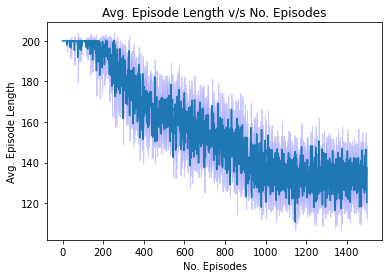

In [9]:
import matplotlib.pyplot as plt
plt.plot(np.arange(iterations), episode_lengths_avg)
plt.fill_between(np.arange(iterations), episode_lengths_avg - episode_lengths_std / 2, \
                 episode_lengths_avg + episode_lengths_std / 2, color='blue', alpha=0.2)
plt.title('Avg. Episode Length v/s No. Episodes')
plt.xlabel('No. Episodes')
plt.ylabel('Avg. Episode Length')
plt.savefig("/home/sahil/Desktop/CS 687/Project/sarsa_lambda_mountaincar.png")
plt.show()